In [25]:
import numpy as np
from scipy import sparse


*   NX = Number of x grid blocks
*   NY = Number of Y grid blocks
*   W = Width of Reservior
*   h = Height of Reservior
*   L = Length of Reservior
*   rw = Wellbore radius
*   mu = Fluid viscosity
*   dt = Change in time
*   Bw = Formation volume factor
*   Ct = Rock Compressibility
*   t = total time
*   n = Number of wells
*   Pi = Initial Pressure
*   Porosity = ((NX * NY)*0.3)*T
*   Permeability = ((NX * NY)*0.75)*T





















In [26]:
def Res_properties():
   NX = 89
   NY = 89
   L = 10000
   W = 20000
   h = 300
   rw = float(.25)
   dt = float(1)
   mu = float(1)
   Bw = float(1.36)  # Define Bw here
   ct =  float( 1e-06)
   Pi = int (3000)
   Porosity= (np.ones([NX, NY])*.3).T
   Permeability = (np.ones([NX, NY])*75).T
   t = int (100)
   n = 5
   return NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n

NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n= Res_properties()

dx = L/NX
dy= W/NY

Area_x = h*dx
Area_y = h*dy

In [27]:
def T_inter (Permeability, Permeability_2, mu, Bw, dx, Area):

    if Permeability == 0 or Permeability_2 == 0:
      t_inter = 0
    else:
      k_inter = 2*(1/float(Permeability) + 1/float(Permeability_2))**(-1)
      t_inter =  k_inter*Area/(mu*Bw*dx)*(6.332e-03)
    return t_inter
from scipy import sparse
import math as m

def T_array (NX, NY, Permeability, mu, Bw, dx, dy, Area_x, Area_y):
    N = NX*NY
    T = sparse.lil_matrix(np.zeros([N, N]))

    for i in range(N):
        if (i+1)- NX > 0:
               T[i, i-NX]= -T_inter(Permeability [2-m.floor((i)/NX), i-m.floor(i/NX) *NX], Permeability [3-m.floor((i)/NX),i-m.floor(i/NX)*NX], mu,  Bw,dy,Area_x)
               T[i, i]  = T[i, i] + T_inter (Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX], Permeability[3-m.floor((i)/NX),i-m.floor(i/NX)*NX], mu, Bw, dy, Area_x)

        if (i+1) + NX <= N: #shows blocks below top edge
             T[i, i+NX]=-T_inter(Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX], Permeability[1-m.floor((i)/NX),i-m.floor(i/NX) *NX],mu, Bw, dy, Area_x)
             T[i, i] = T[i, i] + T_inter (Permeability [2-m.floor((i)/NX),i-m.floor(i/NX) *NX], Permeability[1-m.floor((i)/NX),i-m.floor(i/NX) *NX], mu, Bw, dy, Area_x)

        if (i+1)% NX != 0: #Shows blocks except right edge
           T[i, i+1]=-T_inter(Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX], Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX+1], mu, Bw, dx, Area_y)
           T[i, i] = T[i, i] + T_inter (Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX],  Permeability [2-m.floor((i)/NX),i-m.floor(i/NX) *NX+1],mu, Bw, dx, Area_y)

        if (i+1)% NX != 1: #Shows blocks except left edge, changed != 0 to != 1
           T[i, i-1]=-T_inter(Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX], Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX-1], mu, Bw, dx, Area_y)
           T[i, i] = T[i, i] + T_inter (Permeability [2-m.floor((i)/NX),i-m.floor(i/NX)*NX],  Permeability [2-m.floor((i)/NX),i-m.floor(i/NX) *NX-1],mu, Bw, dx, Area_y)
    return sparse.lil_matrix(T)

In [28]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
import numpy as np

def inter_transm(Permeability, ty, Porosity, NX, NY, t, W, L, h, mu, Bw, dt, ct, Pi, dx, dy, Q, J, B):
    T=T_array (NX, NY, Permeability, mu, Bw, dx, dy, Area_x,Area_y);
    T =  sparse.lil_matrix(T);
    Permeability = Permeability.reshape(1, NX*NY)
    Porosity = Porosity.reshape(1, NX, NY)

    P_0 =np.ones([NX*NY, 1])*Pi
    P_n =  sparse.lil_matrix(P_0)

    P= np.zeros([NX*NY,t+1])
    P[:,0] = P_0.transpose()

    for i in range(t):
        a = T+J+B/dt
        b = np.dot((B/dt), P_n) + Q
        P_nplus1 = spsolve(a,b)
        P_n = sparse.lil_matrix(P_nplus1.reshape(-1, 1)) # Update P_n
        P[:,i+1] = P_nplus1 # Use correct index

    x = [j*L/(NX-1) for j in range(NX)] # Corrected variable name and indentation
    y = [k*W/(NY-1) for k in range(NY)] # Corrected variable name and indentation

    return P,x,y,T

In [29]:
import math as m
from scipy import sparse
import random

NX, NY, L, W, h, rw, dt, mu, Bw, ct, Pi, Porosity, Permeability, t, n = Res_properties()

wells = np.zeros([n, 4])
Q = sparse.lil_matrix(np.zeros([NX*NY, 1]))
J = sparse.lil_matrix(np.zeros([NX*NY, NX*NY]))

x_loc= [3000, 10000, 5000, 15000, 8000]
y_loc= [5000, 3000, 12000, 11000, 10000]
welltype = [1, 1, 1, 1, 2]
oper_con = [3000, 2000, 1000, 1000, 8000]


for i in range(n):
    wells[i,:] = [x_loc[i], y_loc[i], welltype[i], oper_con[i]] # Corrected assignment

    # Calculate linear index l for the grid block containing the well
    l = (m.ceil(y_loc[i]/dy)-1) *NX+m.ceil(x_loc[i]/dx)-1
    l = int(l) # Ensure l is an integer index

    if welltype[i] == 1: # Producer
        # Assuming Permeability is a 2D array (NY, NX)
        # Need to convert linear index l back to 2D indices (row, col)
        row = l // NX
        col = l % NX
        # Corrected calculation of J[l,l] with proper handling of the geometric mean part
        J[l,l] = (6.33e-3) * (2 * m.pi * Permeability[row, col] * h) / (mu * Bw * m.log(0.28 * (dx**2 + dy**2)**0.5 / rw))
        # Corrected assignment to Q[l] for producer wells (rate constraint)
        Q[l,0] = -oper_con[i] # Negative for production

    elif welltype[i] == 2: # Injector (or Pressure constraint)
        # Corrected assignment to Q[l] for injector wells (pressure constraint)
        # In case of pressure constraint, Q[l] is the pressure value
        Q[l,0] = oper_con[i]
        # J[l,l] should be calculated for injector as well if using Peaceman approach
        # Need to convert linear index l back to 2D indices (row, col)
        row = l // NX
        col = l % NX
        J[l,l] = (6.33e-3) * (2 * m.pi * Permeability[row, col] * h) / (mu * Bw * m.log(0.28 * (dx**2 + dy**2)**0.5 / rw))


# Ensure Q and J are sparse matrices (already done inside the loop, but good to be explicit)
Q = sparse.lil_matrix(Q)
J = sparse.lil_matrix(J)

# Calculate the accumulation matrix B
# Assuming Porosity is a 2D array (NY, NX)
B = np.diagflat(Porosity.reshape(NX*NY) * dx * dy * h * ct / Bw) # Reshape Porosity correctly

B = sparse.lil_matrix(B)

# Call inter_transm to perform the simulation
# Note: The second argument of inter_transm is 'ty' which is not used in the function definition.
# Let's assume it was meant to be Porosity based on the function definition.
P, x, y, T = inter_transm(Permeability, Porosity, Porosity, NX, NY, t, W, L, h, mu, Bw, dt, ct, Pi, dx, dy, Q, J, B)

# Reshape pressure results for visualization
P_time_3 = P[:,3].reshape ([NY, NX]) # Reshape to (NY, NX)
P_time_20 = P[:,20].reshape([NY, NX]) # Reshape to (NY, NX)
P_time_50 = P[:,50].reshape([NY, NX]) # Reshape to (NY, NX)

# Calculate Q_time and P_time (This part needs careful review based on well type and constraints)
# The original logic here seems to mix rate and pressure constraints and has indexing issues with P.
# Let's try to correct this part based on typical reservoir simulation outputs.

Q_time = np.zeros([t+1, welltype.count(1)]) # Store production rates over time (including initial time)
P_well = np.zeros([t+1, n]) # Store pressure at each well location over time (including initial time)


producer_idx = [i for i, wt in enumerate(welltype) if wt == 1]
injector_idx = [i for i, wt in enumerate(welltype) if wt == 2]

for time_step in range(t+1):
    for i in range(n):
        l = (m.ceil(y_loc[i]/dy)-1) *NX+m.ceil(x_loc[i]/dx)-1
        l = int(l)

        P_well[time_step, i] = P[l, time_step] # Store pressure at well location

        if welltype[i] == 1: # Producer (Rate constrained)
            # Calculate flowing bottomhole pressure for producers
            # Assuming J[l,l] is the well index
            # P_bhp = P_grid - Q_producer / J_well
             producer_col_idx = producer_idx.index(i)
             if J[l,l] != 0:
                 # Recalculate Q based on the solved pressure if needed, or use the constraint
                 # For rate constrained wells, the solved P already accounts for the rate.
                 # We can calculate the flowing bottomhole pressure:
                 Q_time[time_step, producer_col_idx] = -oper_con[i] # Store the constant production rate

        elif welltype[i] == 2: # Injector (Pressure constrained)
             # Calculate injection rate for pressure constrained wells
             # Q_injector = J_well * (P_bhp - P_grid)
             # Assuming oper_con[i] is the constant bottomhole pressure for the injector
             if J[l,l] != 0:
                 P_bhp_injector = oper_con[i]
                 Q_injector = J[l,l] * (P_bhp_injector - P[l, time_step])
                 # Need a way to store injection rates - perhaps in a separate array or modify Q_time structure
                 # For simplicity, let's just print or handle this separately if needed.
                 pass # Placeholder for handling injector rates if required

# The original logic for calculating Q_time and P_time after the main loop was also problematic.
# The loop structure and calculations need to align with how well constraints are handled
# and how results are desired (e.g., well pressures, well rates).
# The corrected code above attempts to store well pressures and producer rates during the time loop.

# You can now use P_well and Q_time for analysis and plotting.

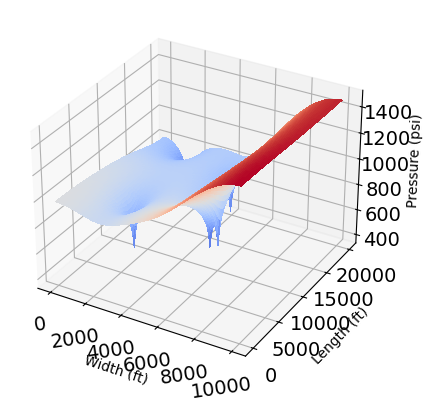

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Create 2D coordinate arrays for plotting the surface
X, Y = np.meshgrid(x, y)

ax.plot_surface(X.T, Y.T, P_time_50, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel('Width (ft)')
ax.set_ylabel('Length (ft)')
ax.set_zlabel('Pressure (psi)')
plt.tick_params(axis='both', labelsize=14)
plt.xticks(rotation=8)

plt.show()